In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import pandas as pd

import sys
sys.path.append("../src")

from data.GDGT_datasets import load_duncan2023

# Regression model for TEX86

Based on [the TEX$_\textsf{86}$ Wikipedia article](https://en.wikipedia.org/wiki/TEX86#Calibrations).

In [2]:
modern_data = load_duncan2023(as_frame=True)
modern_data.frame

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Age (Ma),Longitude,Latitude,SST
0,0.541400,0.021900,0.006800,0.002400,0.424800,0.002600,0.0,-158.2700,-77.4700,-0.90
1,0.520800,0.015000,0.004000,0.001800,0.455500,0.002900,0.0,-108.6100,-74.1000,-1.70
2,0.515200,0.020600,0.005700,0.003000,0.452700,0.002900,0.0,-134.5200,-73.9400,-1.80
3,0.505600,0.023200,0.006400,0.002700,0.459000,0.003200,0.0,-125.8100,-72.5600,-1.60
4,0.477800,0.034500,0.011300,0.003000,0.468300,0.005000,0.0,-104.0100,-71.7500,-1.80
...,...,...,...,...,...,...,...,...,...,...
944,0.411485,0.056507,0.035875,0.004527,0.477110,0.014496,0.0,-93.9543,-37.5013,16.08
945,0.405664,0.057875,0.042174,0.004044,0.475397,0.014846,0.0,-95.3437,-37.4910,16.01
946,0.454915,0.066376,0.044500,0.004564,0.416880,0.012765,0.0,-92.3805,-37.3560,16.05
947,0.412693,0.068527,0.049505,0.006042,0.445106,0.018128,0.0,-85.0265,-36.2195,16.35


In [3]:
paleo_data = load_duncan2023(modern=False,as_frame=True)
paleo_data.frame

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Age (Ma),Longitude,Latitude,SST
0,0.484848,0.050635,0.017581,0.002988,0.437388,0.006560,0.00079,68.385,-50.567,NaN
1,0.496196,0.059309,0.025377,0.003575,0.406032,0.009511,0.00165,68.385,-50.567,NaN
2,0.490190,0.047124,0.016838,0.003104,0.436036,0.006708,0.00196,68.385,-50.567,NaN
3,0.483115,0.067558,0.028432,0.003140,0.405514,0.012241,0.00277,68.385,-50.567,NaN
4,0.500043,0.048536,0.017749,0.003268,0.423546,0.006858,0.00313,68.385,-50.567,NaN
...,...,...,...,...,...,...,...,...,...,...
1821,0.285245,0.054922,0.051441,0.023593,0.549217,0.035583,64.57330,149.928,-59.500,NaN
1822,0.254902,0.057306,0.056167,0.027577,0.562935,0.041113,64.85710,149.928,-59.500,NaN
1823,0.256907,0.057276,0.054197,0.025603,0.570121,0.035897,64.91660,149.928,-59.500,NaN
1824,0.259449,0.058409,0.057487,0.026538,0.556434,0.041683,65.25020,149.928,-59.500,NaN


In [4]:
# Load dataset

df_all = pd.concat([modern_data.frame, paleo_data.frame],axis=0)

compound_names = modern_data.feature_names[:6]
sst_name = modern_data.target.name

N_SAMPLES = 50

observed = df_all[compound_names].values
sst = df_all[sst_name].values

# N_TEST = 100
# idx_valid = np.random.choice(np.arange(len(sst)),N_TEST)
# idx_valid = np.linspace(0,len(sst)-len(sst)//N_TEST,N_TEST).astype(int) + np.random.randint(0,len(sst)//N_TEST,size=N_TEST)

# observed = observed[idx_valid]
# sst = sst[idx_valid]

print(observed.shape)
print(sst.shape)


print(observed.shape,sst.shape)
with pm.Model() as model_tex86:
    GDGTs = pm.ConstantData("GDGTs", observed)
    GDGT_2_ratio = (GDGTs[:,2]+GDGTs[:,3]+GDGTs[:,5])/(GDGTs[:,1]+GDGTs[:,2]+GDGTs[:,3]+GDGTs[:,5])
    print(GDGT_2_ratio.eval().shape)
    a = pm.Normal("a",30,10)
    b = pm.Normal("b",30,10)
    σ = pm.HalfNormal("σ",10)
    SST_TEX86H  = pm.Normal("SST_TEX86H",mu=a+b*pm.math.log(GDGT_2_ratio),sigma=σ,observed=sst)
    idata_tex86 = pm.sample_prior_predictive(samples=N_SAMPLES)  

(2775, 6)
(2775,)
(2775, 6) (2775,)
(2775,)


/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in SST_TEX86H contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1930DEEA0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [SST_TEX86H_observed, SST_TEX86H_unobserved, a, b, σ]


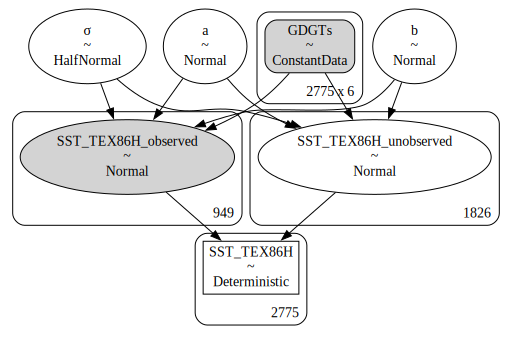

In [5]:
pm.model_to_graphviz(model_tex86)

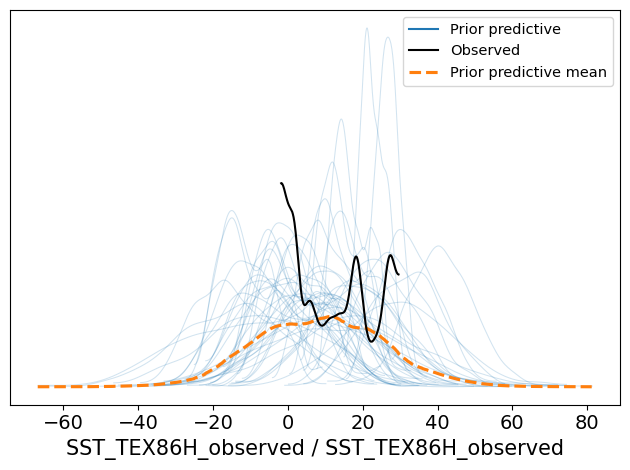

In [6]:
az.plot_ppc(idata_tex86,group="prior")
plt.tight_layout()

In [7]:
with model_tex86:
    idata_tex86.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, σ, SST_TEX86H_unobserved]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 81 seconds.


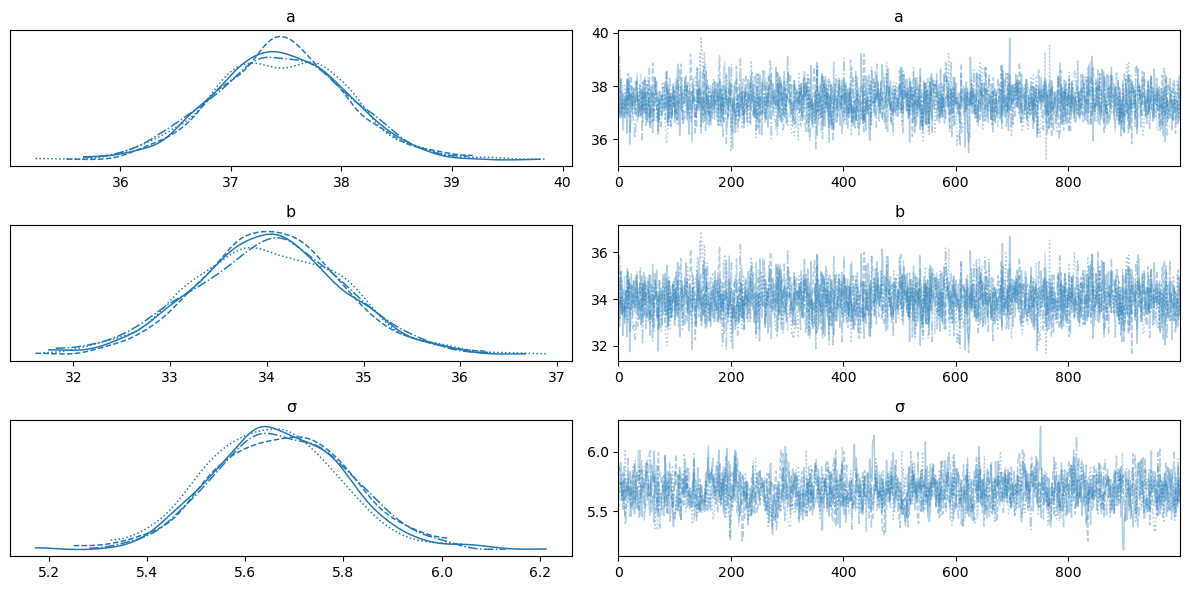

In [8]:
var_names = ["a","b"]+["σ"]
ax = az.plot_trace(idata_tex86,var_names=var_names)
plt.tight_layout()

In [9]:
az.summary(idata_tex86,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,37.449,0.593,36.328,38.557,0.015,0.011,1564.0,2051.0,1.0
b,34.021,0.765,32.498,35.412,0.020,0.014,1543.0,2047.0,1.0
σ,5.669,0.134,5.411,5.911,0.004,0.003,896.0,1705.0,1.0


In [10]:
with model_tex86:
    idata_tex86.extend(pm.sample_posterior_predictive(idata_tex86))

/usr/local/Caskroom/miniforge/base/envs/sp/lib/python3.10/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x19BE24120>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [SST_TEX86H_observed]


<Axes: xlabel='SST_TEX86H_observed / SST_TEX86H_observed'>

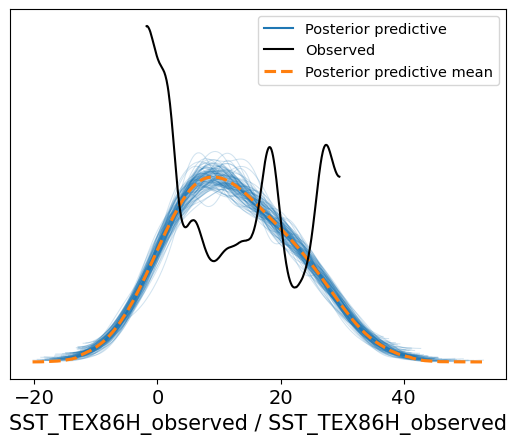

In [11]:
az.plot_ppc(idata_tex86, num_pp_samples=100)

(1826,)


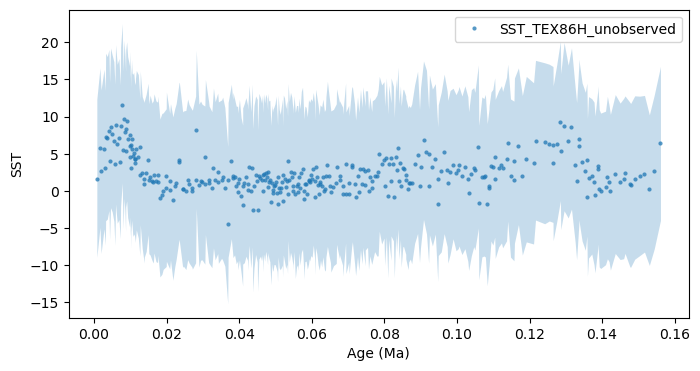

In [12]:
# Stack samples into a single dimension
stacked = az.extract(idata_tex86)

fig, ax = plt.subplots(1,1,figsize=(8,4))

unobserved = "SST_TEX86H_unobserved"
# mean
y = stacked[unobserved].mean(dim="sample")#*sst_sd+sst_mu
# 94% HDI
y_hdi_lo = stacked[unobserved].quantile(0.03,dim="sample")#*sst_sd+sst_mu
y_hdi_hi = stacked[unobserved].quantile(0.97,dim="sample")#*sst_sd+sst_mu
print(y.shape)

age = paleo_data.frame["Age (Ma)"]

age_max = 0.16
this_age = age[age<age_max]
this_y = y[age.values<age_max]
this_y_hdi_lo = y_hdi_lo[age.values<age_max]
this_y_hdi_hi = y_hdi_hi[age.values<age_max]
l, = ax.plot(this_age,this_y,ls='',marker='.',mew=0,alpha=0.75,label=unobserved)
ax.fill_between(this_age,this_y_hdi_lo,this_y_hdi_hi,lw=0,color=l.get_color(),alpha=0.25)
ax.set_ylabel("SST")
ax.set_xlabel("Age (Ma)")

ax.legend();

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc

Last updated: Thu Nov 09 2023

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.17.2

pymc: 5.9.1

numpy     : 1.24.4
arviz     : 0.16.1
sys       : 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:09:20) [Clang 16.0.6 ]
matplotlib: 3.8.1
pandas    : 2.1.2
pymc      : 5.9.1

Watermark: 2.4.3

